In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = np.load('digitsMnist.npy', allow_pickle = True)
data[1]

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

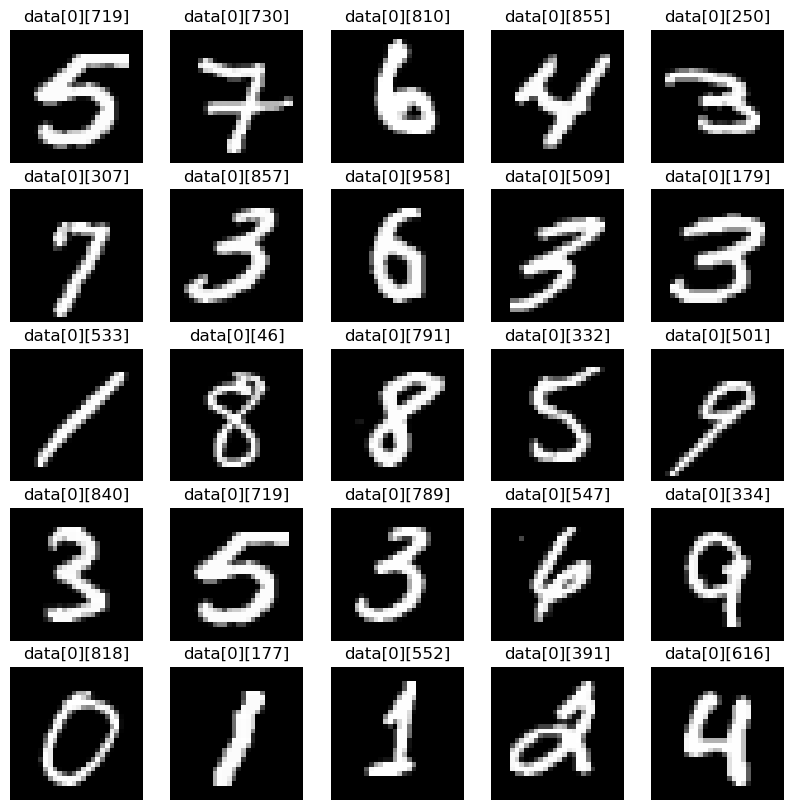

In [3]:
fig = plt.subplots(5,5, figsize = (10,10))

for i in np.arange(0, 25):
    index = np.random.randint(0, 1000)
    plt.subplot(5, 5, i+1)
    img = data[0][index].reshape(28,28)
    plt.imshow(img, cmap = 'gray')
    plt.title(f'data[0][{index}]')
    plt.axis('off')
plt.show()

In [4]:
X_all_forTrain = data[0]
Y_all_forTrain = data[1]

X_all_forVal = data[2]
Y_all_forVal = data[3]

In [5]:
X_all_forTrain = X_all_forTrain/255
X_all_forVal = X_all_forVal/255

In [6]:
X_all_train, X_all_test, Y_all_train, Y_all_test = train_test_split(X_all_forTrain, 
                                                    Y_all_forTrain, 
                                                    test_size = 0.22, random_state = 55)

In [7]:
X_all_train_tensor = torch.tensor(X_all_train, dtype = torch.float32)
X_all_test_tensor = torch.tensor(X_all_test, dtype = torch.float32)
Y_all_train_tensor = torch.tensor(Y_all_train, dtype = torch.long)
Y_all_test_tensor = torch.tensor(Y_all_test, dtype = torch.long)

In [8]:
X_all_val_tensors = torch.tensor(X_all_forVal, dtype = torch.float32)
Y_all_val_tensors = torch.tensor(Y_all_forVal, dtype = torch.long)

In [9]:
trainDataset = TensorDataset(X_all_train_tensor, Y_all_train_tensor)
testDataset = TensorDataset(X_all_test_tensor, Y_all_test_tensor)
valDataset = TensorDataset(X_all_val_tensors, Y_all_val_tensors)

In [31]:
train_loader = DataLoader(trainDataset, batch_size = 50, shuffle = True)
test_loader = DataLoader(testDataset, batch_size = 50, shuffle = True)
val_loader = DataLoader(valDataset, batch_size = 50, shuffle = True)

In [33]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.fc1 = nn.Linear(784, 472)
        #self.fc2 = nn.Linear(628, 472)
        #self.fc3 = nn.Linear(472, 316)
        self.fc4 = nn.Linear(472, 160)
        self.fc5 = nn.Linear(472, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

In [35]:
simplenet = SimpleNet()

In [37]:
optimizer = optim.Adam(simplenet.parameters(), lr = 0.001)

In [39]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=472, bias=True)
  (fc4): Linear(in_features=472, out_features=160, bias=True)
  (fc5): Linear(in_features=472, out_features=10, bias=True)
  (relu): ReLU()
)

In [41]:
loss_fn = torch.nn.CrossEntropyLoss()

In [43]:
epochs = 25

for epoch in range(epochs):
    training_loss = 0.0
    test_loss = 0.0

    #TRAINING
    for batch in train_loader: #Организуется цикл по батчам из итератора train_loader
        optimizer.zero_grad() #Обнуляем градиенты весов сети внутри оптимизатора перед каждым шагом обучения.
    
        inputs, targets = batch #Извлекаем из батча тензоры входных данных и соответствующих им меток классов.
        inputs = inputs.to(device) #Обнуляем градиенты весов сети внутри оптимизатора перед каждым шагом обучения.
        targets = targets.to(device)
        output = simplenet(inputs) #Получаем предсказания сети относительно входных данных рассматриваемого батча.

        """ Вычисляем функцию потерь, сопоставляя предсказанные значения и 
        правильные ответы. По умолчанию функция возвращает среднее значение ошибки по 
        всем примерам в батче """
        loss = loss_fn(output, targets)
        loss.backward() #Вычисляем градиенты для весов всех связей внутри сети, основываясь на значении функции потерь.

        optimizer.step() #Обновляем значения весов сети, основываясь на результатах предыдущего шага.

        """Накапливаем значение потерь по всей обучающей выборке, 
        умножая среднюю ошибку по элементам батча на размер батча"""
        training_loss += loss.data.item() * inputs.size(0)

    num_correct = 0 #Объявляем переменную для накопления количества правильных предсказаний

    #TESTING
    for batch in test_loader: #Организуется цикл по батчам из итератора test_loader
        inputs, targets = batch
        inputs = inputs.to(device) 
        targets = targets.to(device)
        output = simplenet(inputs)

        loss = loss_fn(output, targets)
        test_loss += loss.data.item() * inputs.size(0)

        """Сравниваем предсказанные классы (индексы максимумов тензора 
        softmax(output) с истинными метками классов. В результате получаем логический 
        тензор, где True соответствует правильным предсказаниям."""
        correct = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_correct += torch.sum(correct).item() #Накопление количества правильных предсказаний по батчам путем суммирования всех значений True

    print(f'Эпоха: {epoch + 1}, Ошибка по обучающей выборке: {round(training_loss, 2)}, Ошибка по тестовой выборке: {round(test_loss, 2)},\
            Точность: {round(num_correct/len(X_all_test), 2)}')

    num_correct = 0
    
    #VALIDATION
    for batch in val_loader:
        inputs, targets = batch
        inputs = inputs.to(device) 
        targets = targets.to(device)
        output = simplenet(inputs)

        correct = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_correct += torch.sum(correct).item()

print(f'Точность по валидационной выборке: {round(num_correct/len(X_all_forVal), 2)}')

Эпоха: 1, Ошибка по обучающей выборке: 63693.76, Ошибка по тестовой выборке: 15462.84,            Точность: 0.77
Эпоха: 2, Ошибка по обучающей выборке: 34985.3, Ошибка по тестовой выборке: 7990.53,            Точность: 0.88
Эпоха: 3, Ошибка по обучающей выборке: 28109.35, Ошибка по тестовой выборке: 7706.8,            Точность: 0.88
Эпоха: 4, Ошибка по обучающей выборке: 26749.0, Ошибка по тестовой выборке: 7585.2,            Точность: 0.88
Эпоха: 5, Ошибка по обучающей выборке: 26017.22, Ошибка по тестовой выборке: 7531.37,            Точность: 0.89
Эпоха: 6, Ошибка по обучающей выборке: 25402.76, Ошибка по тестовой выборке: 7442.04,            Точность: 0.89
Эпоха: 7, Ошибка по обучающей выборке: 24997.65, Ошибка по тестовой выборке: 7465.09,            Точность: 0.89
Эпоха: 8, Ошибка по обучающей выборке: 24722.71, Ошибка по тестовой выборке: 7511.15,            Точность: 0.89
Эпоха: 9, Ошибка по обучающей выборке: 24492.65, Ошибка по тестовой выборке: 7422.92,            Точность: 